In [43]:

from plotnine import *
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [44]:
data = []
for csv in os.listdir('./data/'):
    df = pd.read_csv('./data/' + csv)
    df.rename(columns={'state_cd' : 'state_code', 'district_cd' : 'district_code'}, inplace=True)
    df.dropna(inplace=True)
    data.append(df.copy())

In [45]:
merged_data = pd.concat(data)

In [46]:
student_counts = [i[i.columns[7:]].sum().sum() for i in data]
academic_years = merged_data['ac_year'].unique()
stud_df = pd.DataFrame()
stud_df['Total_Student_Enrolment_Count'] = student_counts
stud_df['Academic_Year'] = academic_years

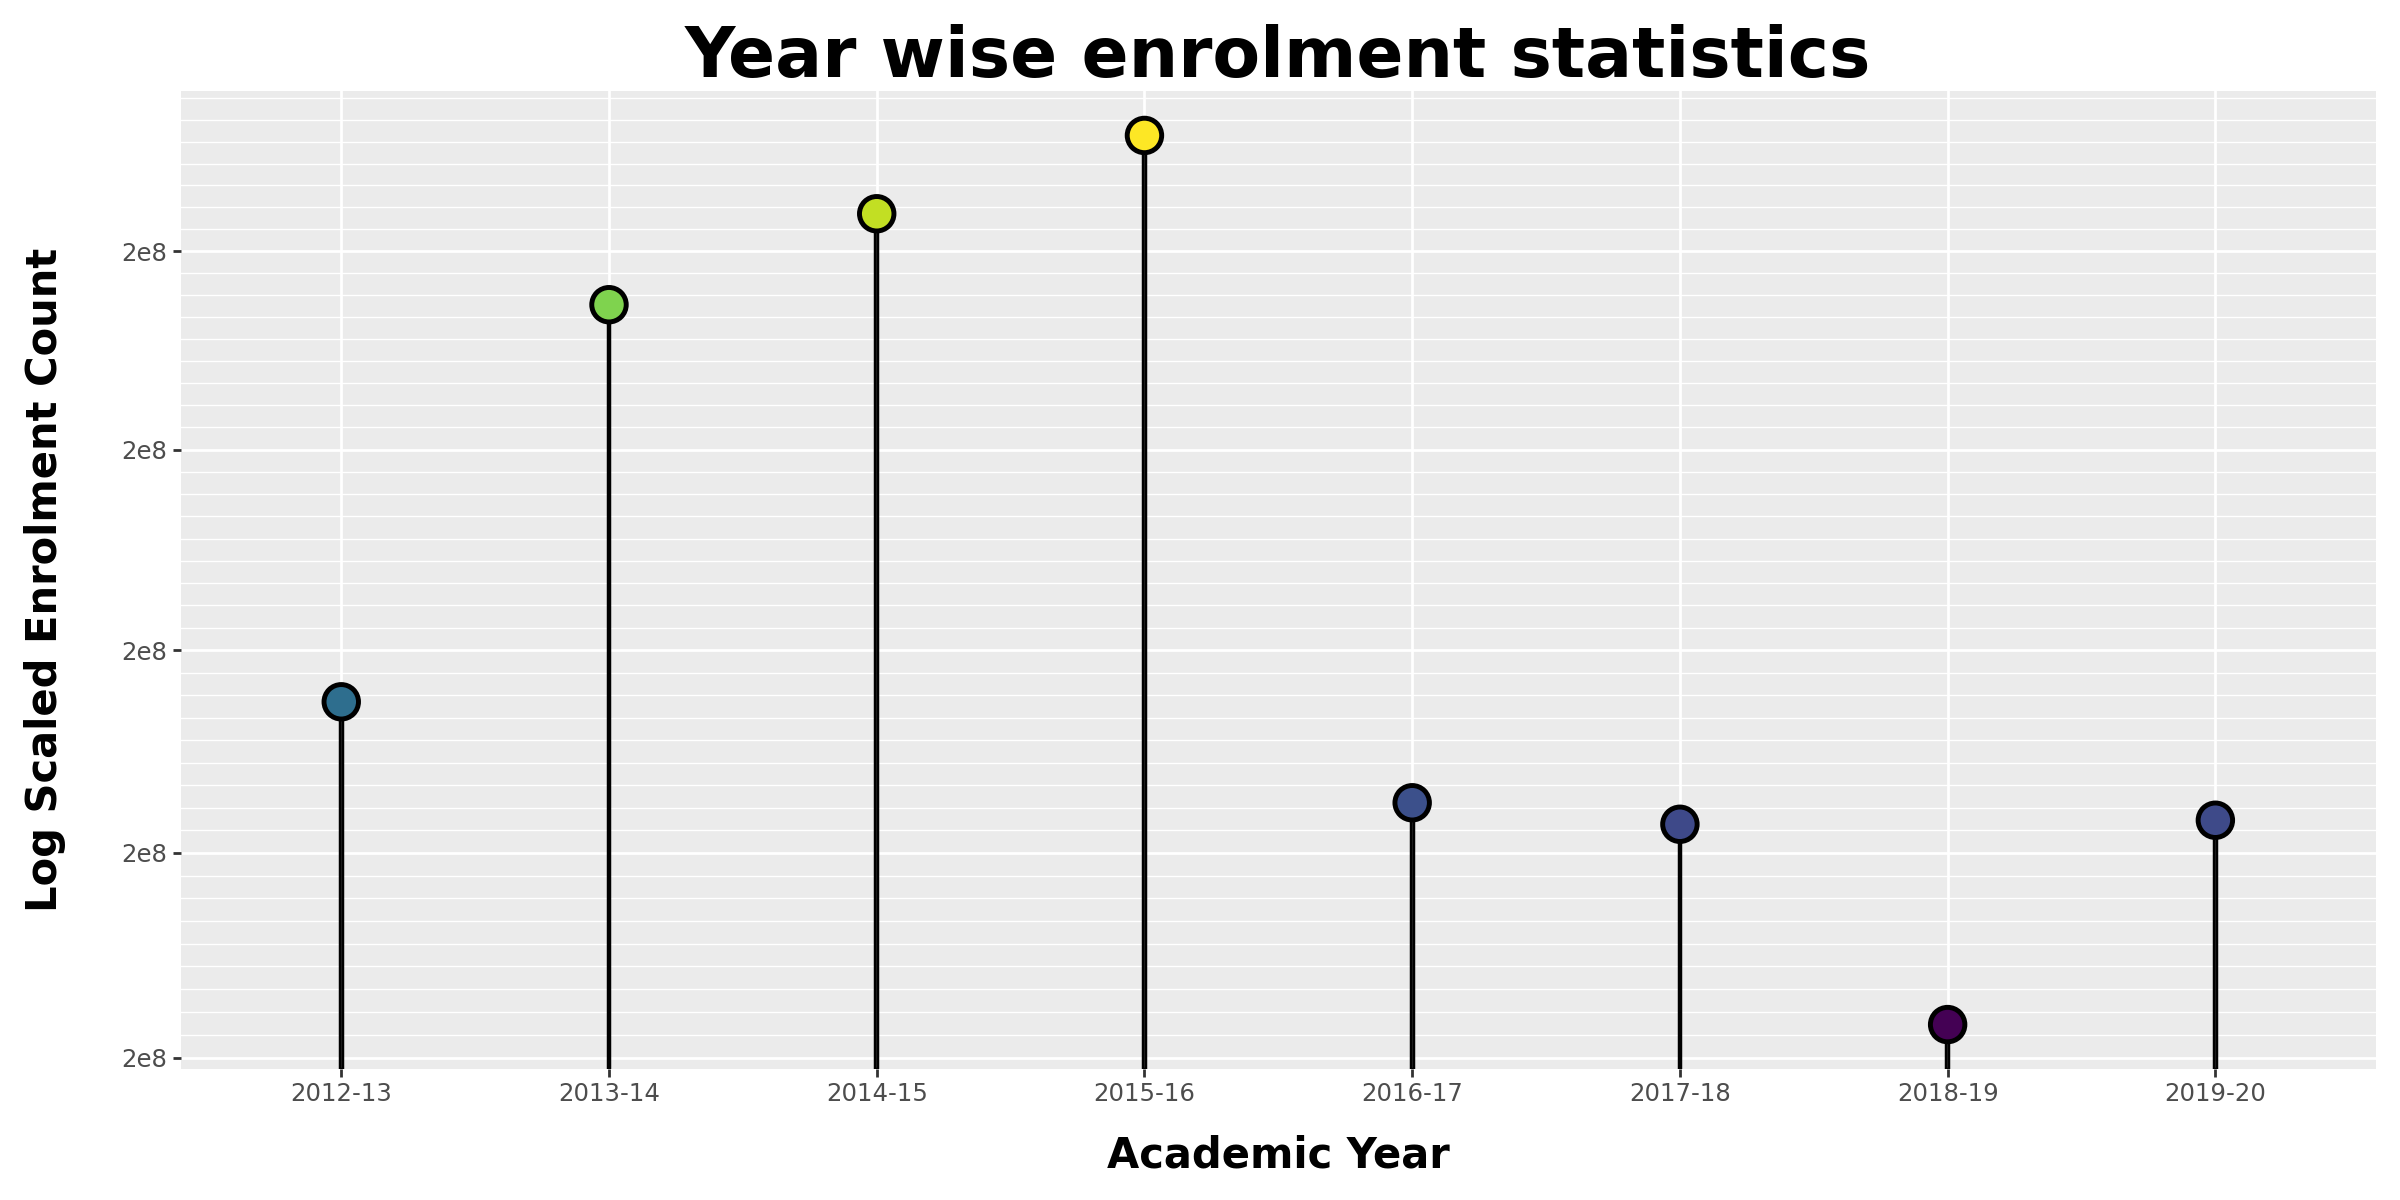

In [47]:
bar = (
    ggplot(stud_df, aes(x='Academic_Year', y='Total_Student_Enrolment_Count', fill='Total_Student_Enrolment_Count', color='Total_Student_Enrolment_Count')) +
    geom_bar(aes(), width=0.01, alpha=0.8, stat='identity',color='black',fill='black') +
    geom_point(size=6, stroke=1, color='black') +
    scale_y_log10()+
    scale_fill_continuous(guide=None) +
    scale_color_continuous(guide=None)
    + theme(
        figure_size=(12,6),
        plot_title=element_text(weight='bold', ha='center', va='top', linespacing=3, size=25., margin={
            't': 50,
        }),
        axis_title_x=element_text(weight='bold', linespacing=3, size=15., margin={
            't': 10,
            'l': 10,
            'r': 10,
            'b': 10,
        }),
        axis_title_y=element_text(weight='bold', ha='left', va='center', linespacing=3, size=15., margin={
            't': 10,
            'l': 10,
            'r': 10,
            'b': 10,
        }),


    )
    + xlab('Academic Year')
    + ylab('Log Scaled Enrolment Count')
    + ggtitle('Year wise enrolment statistics')


)

print(bar)

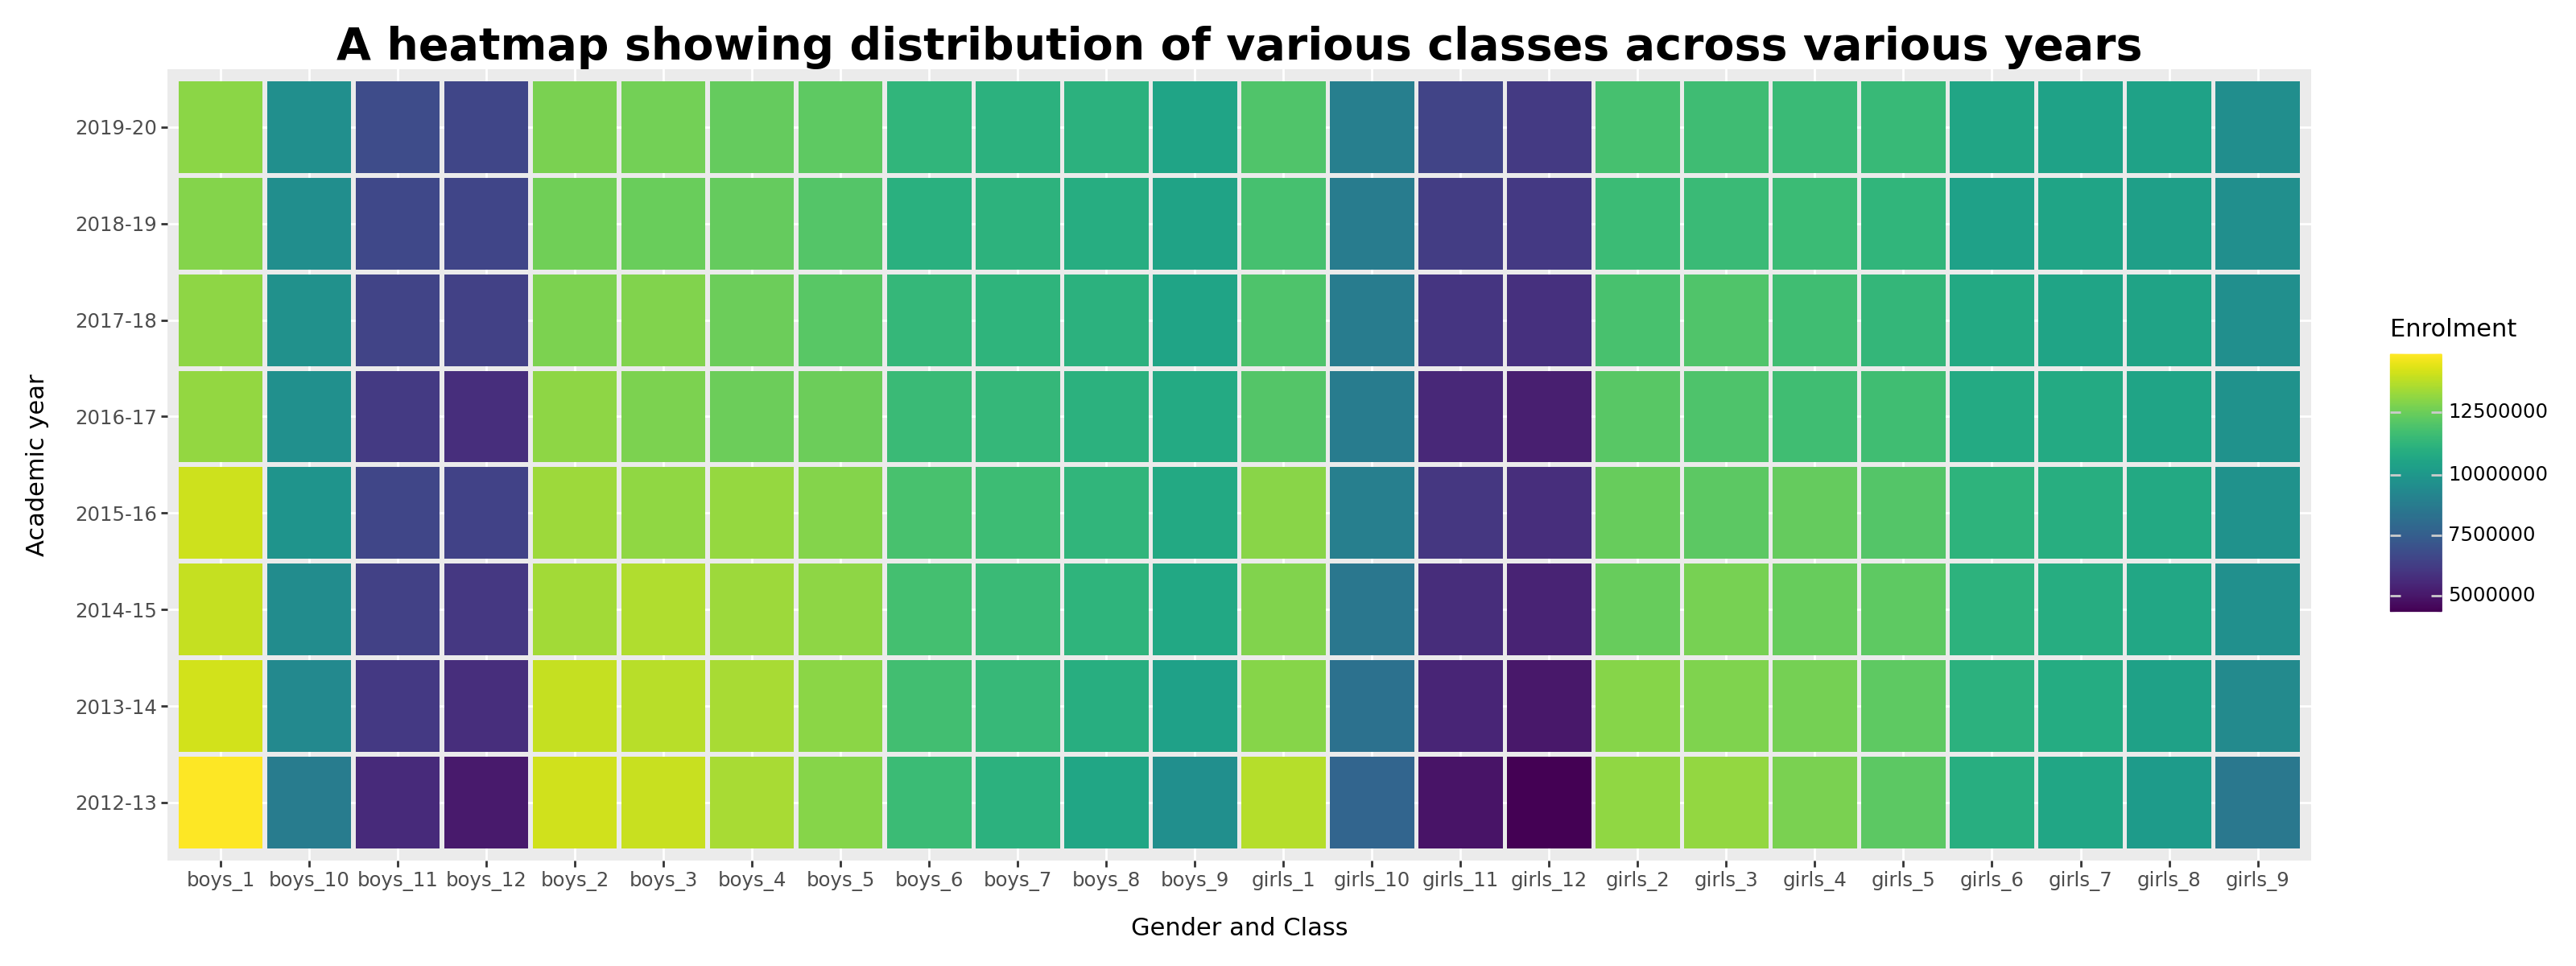

In [48]:
temp = [df[df.columns[6:]].sum(axis=0).values for df in data]
temp = np.array(temp)
boy_classes = ['boys_'+str(i) for i in range(1, 13)]
girl_classes = ['girls_'+str(i) for i in range(1, 13)]
columns = boy_classes+girl_classes
temp = pd.DataFrame(temp, columns=columns)
temp['ac_year'] = merged_data['ac_year'].unique()
temp_melted = pd.melt(temp, value_vars=temp.columns[:-1], id_vars=[
                      'ac_year'], value_name='enrolment', var_name='class')

heatmap = (
    ggplot(temp_melted, aes(x='class', y='ac_year', fill='enrolment'))
    + geom_tile(stat='identity',
                mapping=aes(width=0.95, height=0.95)
                )
    + theme(figure_size=[16, 6], legend_title=element_text(text='Enrolment'),  
            plot_title=element_text(weight='bold', ha='center', va='top', linespacing=3, size=20., margin={
            't': 50,
            }))
    + xlab('Gender and Class')
    + ylab('Academic year')
    + ggtitle('A heatmap showing distribution of various classes across various years')


)

print(heatmap)

In [49]:

temp_data = []
for df in data:
    cols = df.columns[6:]
    sums = df[cols].sum(axis=1)
    temp = pd.DataFrame()
    districts = df['district_name']
    temp['district_name'] = districts
    temp['district_enrolment'] = sums
    temp_data.append(temp)
    

In [50]:
merged_data = pd.concat(temp_data).groupby('district_name')[
    'district_enrolment'].sum().reset_index()
merged_data
merged_data.dropna(inplace=True)
temp = merged_data
temp = temp.sort_values(by='district_enrolment', ascending=False)
temp

district_name  district_enrolment
560           PUNE            15168598
697          THANE            13965123
277         JAIPUR            13356711
468    MURSHIDABAD            13230256
12       ALLAHABAD            11143763
..             ...                 ...
180  DIBANG VALLEY               11197
377        KOMJONG                8319
408      LEPA RADA                4159
523  PAKKE KESSANG                2801
634       SHI YOMI                2507

[779 rows x 2 columns]

In [51]:
from sklearn.manifold import TSNE

n_data = {}
for df in data:
    ac_yr = df['ac_year'][0]
    cols = df.columns[6:]
    for column in cols:
        split_col = column.split('_')
        new_name = split_col[2]+'_'+split_col[1]+'_['+ac_yr[2:]+']'
        n_data[new_name] = df[column]

temp = pd.DataFrame(n_data).T
temp = temp.fillna(0)
sums = temp.sum(axis=1)

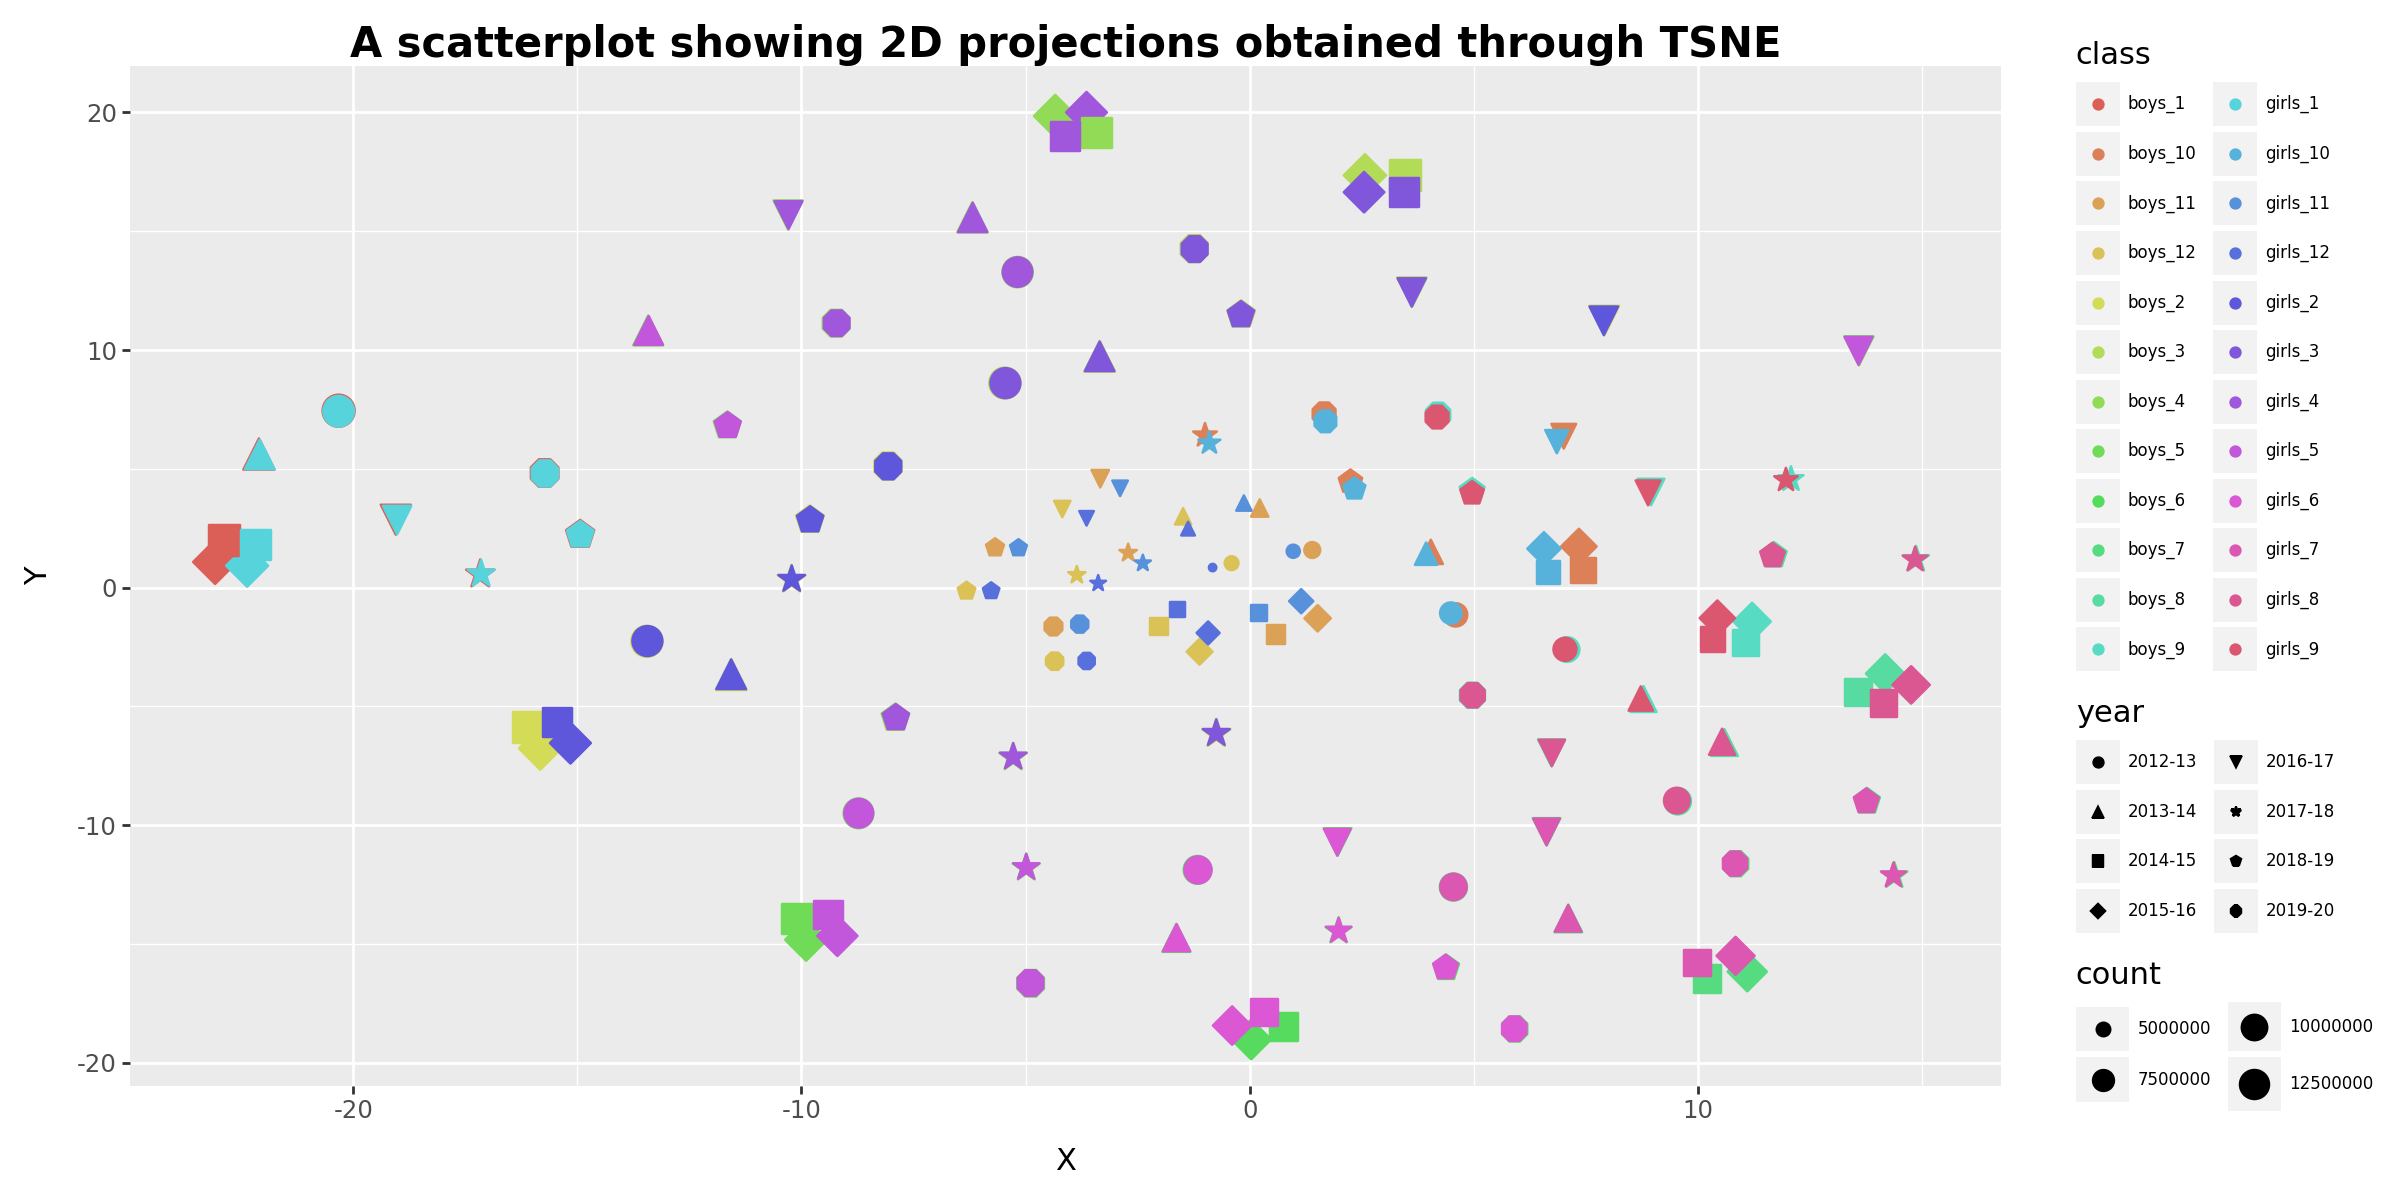

In [52]:


tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(temp)
tsne_df = pd.DataFrame(tsne_data, columns=[
                       'X', 'Y'], index=temp.index)
tsne_df['name'] = tsne_df.index
tsne_df['year'] = tsne_df['name'].map(lambda x :'20'+x.split('_')[2][1:-1])
tsne_df['class'] = tsne_df['name'].map(
    lambda x: x.split('_')[0] + '_'+ x.split('_')[1])
tsne_df['count'] = sums

scat = (ggplot(tsne_df, mapping=aes('X', 'Y',label='name',color='class',shape='year',size='count'))
        +geom_point(alpha=1)
        +theme(figure_size=[12,6], legend_text=element_text(size=6),
               plot_title=element_text(weight='bold', ha='center', va='top', linespacing=3, size=15., margin={
            't': 50,
            })
               )+
        guides(color=guide_legend(ncol=2), shape=guide_legend(ncol=2),size=guide_legend(ncol=2))
        +ggtitle('A scatterplot showing 2D projections obtained through TSNE')

)
print(scat)

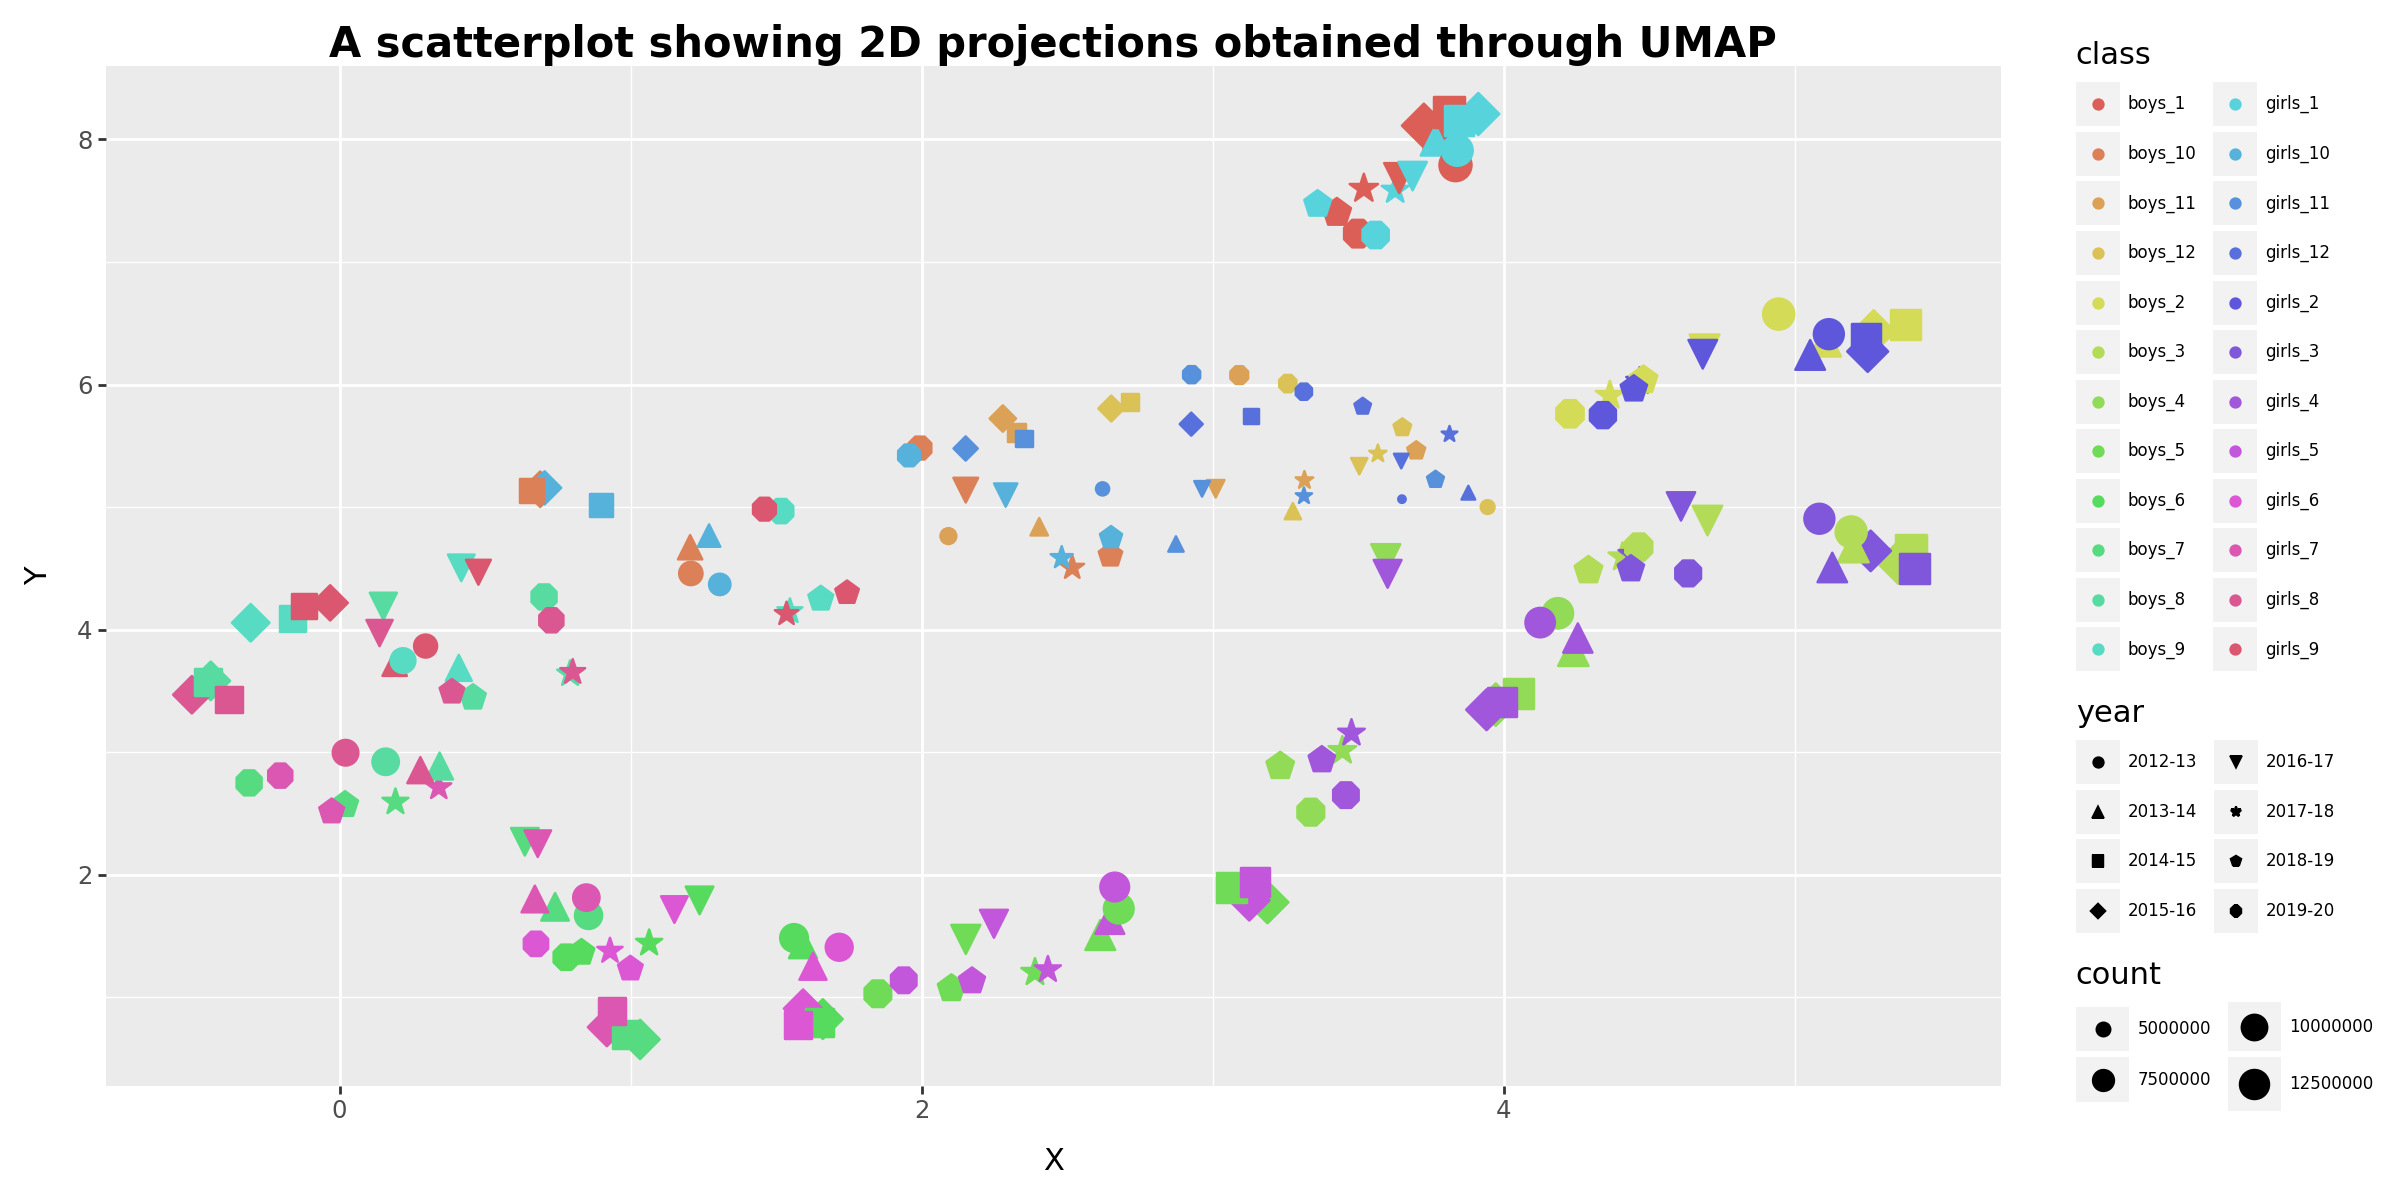

In [53]:
import umap.umap_ as umap

umap_model = umap.UMAP(n_components=2)
umap_data = umap_model.fit_transform(temp) 
umap_df = pd.DataFrame(umap_data, columns=['umap_x', 'umap_y'], index=temp.index)
umap_df['name'] = umap_df.index
umap_df['year'] = umap_df['name'].map(lambda x: '20'+x.split('_')[2][1:-1])
umap_df['class'] = umap_df['name'].map(
    lambda x: x.split('_')[0] + '_' + x.split('_')[1])
umap_df['count'] = sums
scat = (ggplot(umap_df, mapping=aes('umap_x', 'umap_y', label='name', color='class', shape='year', size='count'))
        + geom_point(alpha=1)
        + theme(figure_size=[12, 6], legend_text=element_text(size=6), plot_title=element_text(weight='bold', ha='center', va='top', linespacing=3, size=15., margin={
            't': 50,
        })) +
        guides(color=guide_legend(ncol=2), shape=guide_legend(
            ncol=2), size=guide_legend(ncol=2))
        + ggtitle('A scatterplot showing 2D projections obtained through UMAP')
        +xlab('X')
        +ylab('Y')

        )
print(scat)

In [54]:
ndata = []
for df in data :
    boys = df[df.columns[6:18]]
    girls = df[df.columns[18:]]
    ac_yr = df['ac_year'][0]
    ndf = pd.DataFrame()
    ndf[f'boys[{ac_yr}]'] = [boys.sum(axis=1).sum()]
    ndf[f'girls[{ac_yr}]'] = [girls.sum(axis=1).sum()]
    ndata.append(ndf)

In [55]:
import pandas as pd

summed_dfs = []

for df in data:
    yearly_sum = df.groupby('ac_year').sum().reset_index()
    yearly_sum.drop(columns=yearly_sum.columns[1:6],inplace=True)
    summed_dfs.append(yearly_sum)

yearly_sum_df = pd.concat(summed_dfs, ignore_index=True)

yearly_sum_df

ac_year  class_1_boys  class_2_boys  class_3_boys  class_4_boys  \
0  2012-13      14914051      14147212      14009818      13534253   
1  2013-14      14177028      13996352      13797974      13529471   
2  2014-15      13996936      13429759      13672875      13371456   
3  2015-16      14128543      13363775      13172142      13254695   
4  2016-17      13220591      13107456      12845755      12541157   
5  2017-18      13137951      12835512      12901910      12520928   
6  2018-19      12936058      12605180      12479493      12416128   
7  2019-20      13070849      12803741      12653131      12426793   

   class_5_boys  class_6_boys  class_7_boys  class_8_boys  class_9_boys  ...  \
0      13002529      11540616      11097545      10621836       9576581  ...   
1      13086050      11723691      11436675      10965467      10344843  ...   
2      13138075      11773301      11505164      11223386      10670153  ...   
3      12954081      11848108      11598335      11273661      10745130  ...   
4      12529800      11499785      11398414      11107916      10786115  ...   
5      12189250      11397477      11229415      11098172      10504987  ...   
6      12072267      11063184      11155939      10939964      10485140  ...   
7      12297235      11247385      11100061      11080125      10499475  ...   

   class_3_girls  class_4_girls  class_5_girls  class_6_girls  class_7_girls  \
0       13189005       12793212       12260913       10966071       10599036   
1       12859002       12692140       12295021       11099091       10834681   
2       12758057       12472685       12313726       11118348       10911644   
3       12264402       12397725       12093000       11181081       10978143   
4       11975187       11657860       11694073       10769000       10775825   
5       12008244       11686170       11329362       10706012       10530079   
6       11511238       11549957       11274946       10343353       10499546   
7       11651163       11489153       11473448       10565574       10424590   

   class_8_girls  class_9_girls  class_10_girls  class_11_girls  \
0       10101579        8576379         7743724         4917884   
1       10409176        9360106         8279058         5443365   
2       10633931        9626437         8553657         5683141   
3       10714399        9738647         8859055         6000654   
4       10528183        9700151         8743232         5505130   
5       10487067        9573650         8735206         5981330   
6       10265040        9567585         8760239         6218644   
7       10455652        9526165         8865912         6475386   

   class_12_girls  
0         4349284  
1         5041920  
2         5377881  
3         5732626  
4         5239628  
5         5810077  
6         6105541  
7         6140825  

[8 rows x 25 columns]

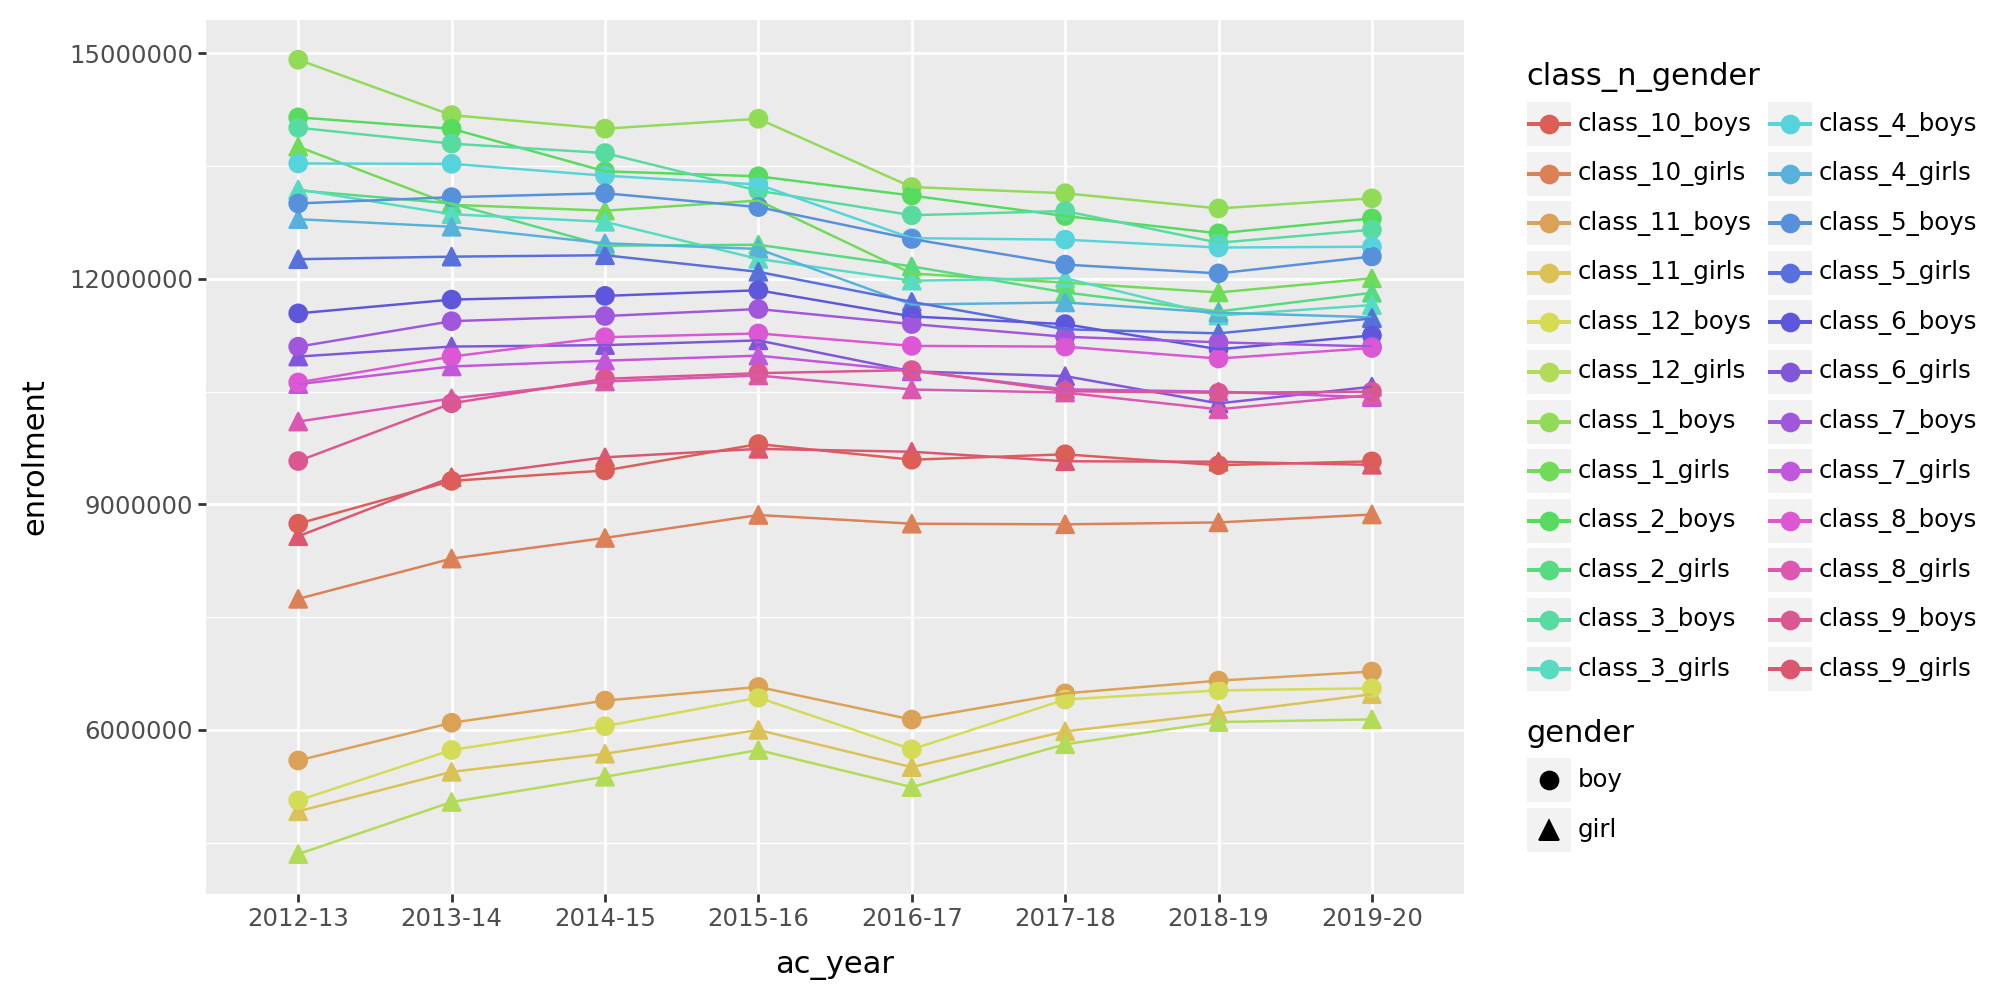

In [56]:
melt = pd.melt(yearly_sum_df, id_vars=[
               'ac_year'], value_vars=yearly_sum_df.columns[1:], var_name='class_n_gender', value_name='enrolment')
melt['gender'] = melt['class_n_gender'].map(
    lambda x: 'boy' if x.split('_')[2] == 'boys' else 'girl')
line = (ggplot(melt, aes(x='ac_year', y='enrolment', color='class_n_gender', group='class_n_gender',shape='gender'))
        + geom_point(size=3)
        + geom_line()
        +theme(figure_size=[10,5])
        )

print(line)

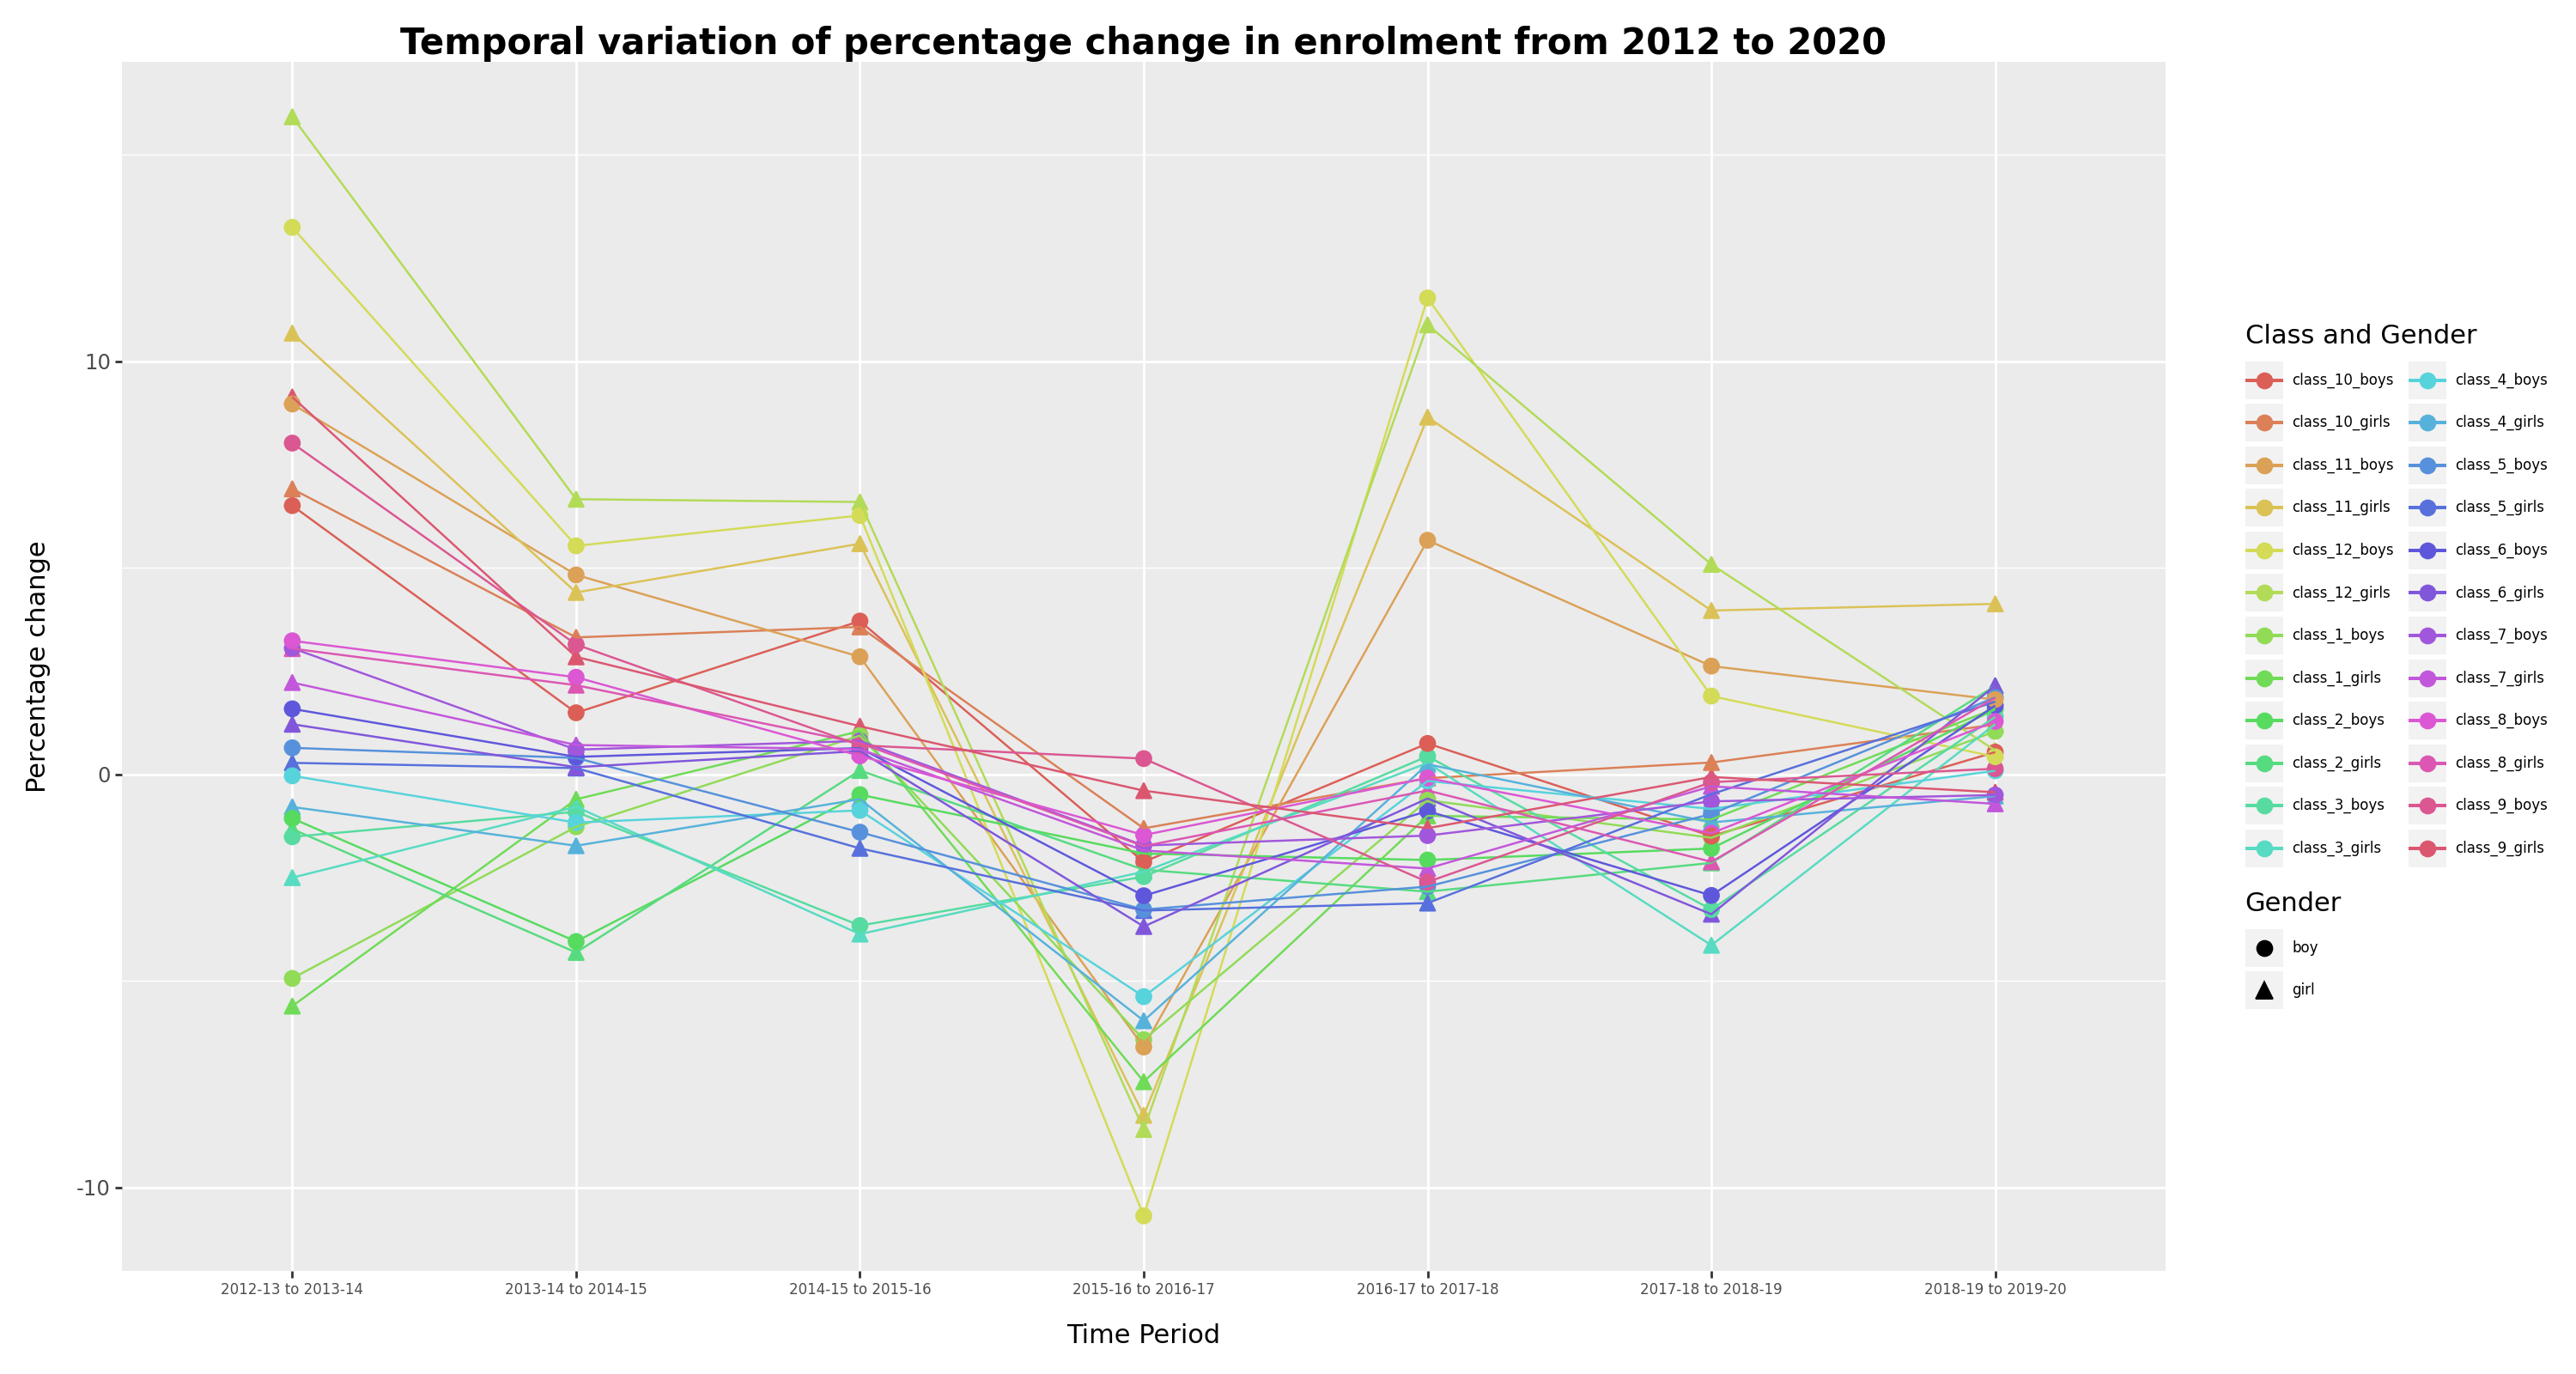

In [57]:

df = yearly_sum_df.copy()


percentage_df = df.drop(columns=['ac_year'])
percentage_change_dfs = []

for i in range(1, len(percentage_df)):
    percentage_change = (
        (percentage_df.iloc[i] - percentage_df.iloc[i - 1]) / percentage_df.iloc[i - 1]) * 100
    period = f"{df['ac_year'].iloc[i]}:{df['ac_year'].iloc[i - 1]}"
    percentage_change_df = pd.DataFrame(percentage_change).transpose()
    percentage_change_df['period'] = period
    percentage_change_dfs.append(percentage_change_df)

percentage_change_df = pd.concat(percentage_change_dfs, ignore_index=True)
percentage_change_df = percentage_change_df[[
    'period'] + [col for col in percentage_change_df.columns if col != 'period']]

percentage_change_df['period'] = percentage_change_df['period'].map(lambda x: x.split(':')[-1] + ' to '+x.split(':')[0])

melt = pd.melt(percentage_change_df, id_vars=[
               'period'], value_vars=percentage_change_df.columns[1:], var_name='class_n_gender', value_name='percentage')
melt['gender'] = melt['class_n_gender'].map(
    lambda x: 'boy' if x.split('_')[2] == 'boys' else 'girl')
line = (ggplot(melt, aes(x='period', y='percentage', color='class_n_gender', group='class_n_gender', shape='gender'))
        + geom_point(size=3)
        + geom_line()
        + theme(figure_size=[15, 8], axis_text_x=element_text(size=6),
                legend_text=element_text(size=6),
                plot_title=element_text(weight='bold', ha='center', va='top', linespacing=3, size=15., margin={
                    't': 50,
                })
                )
        +xlab('Time Period')
        +ylab('Percentage change')
        + labs(color='Class and Gender', shape='Gender')
        +ggtitle('Temporal variation of percentage change in enrolment from 2012 to 2020')
        )

print(line)

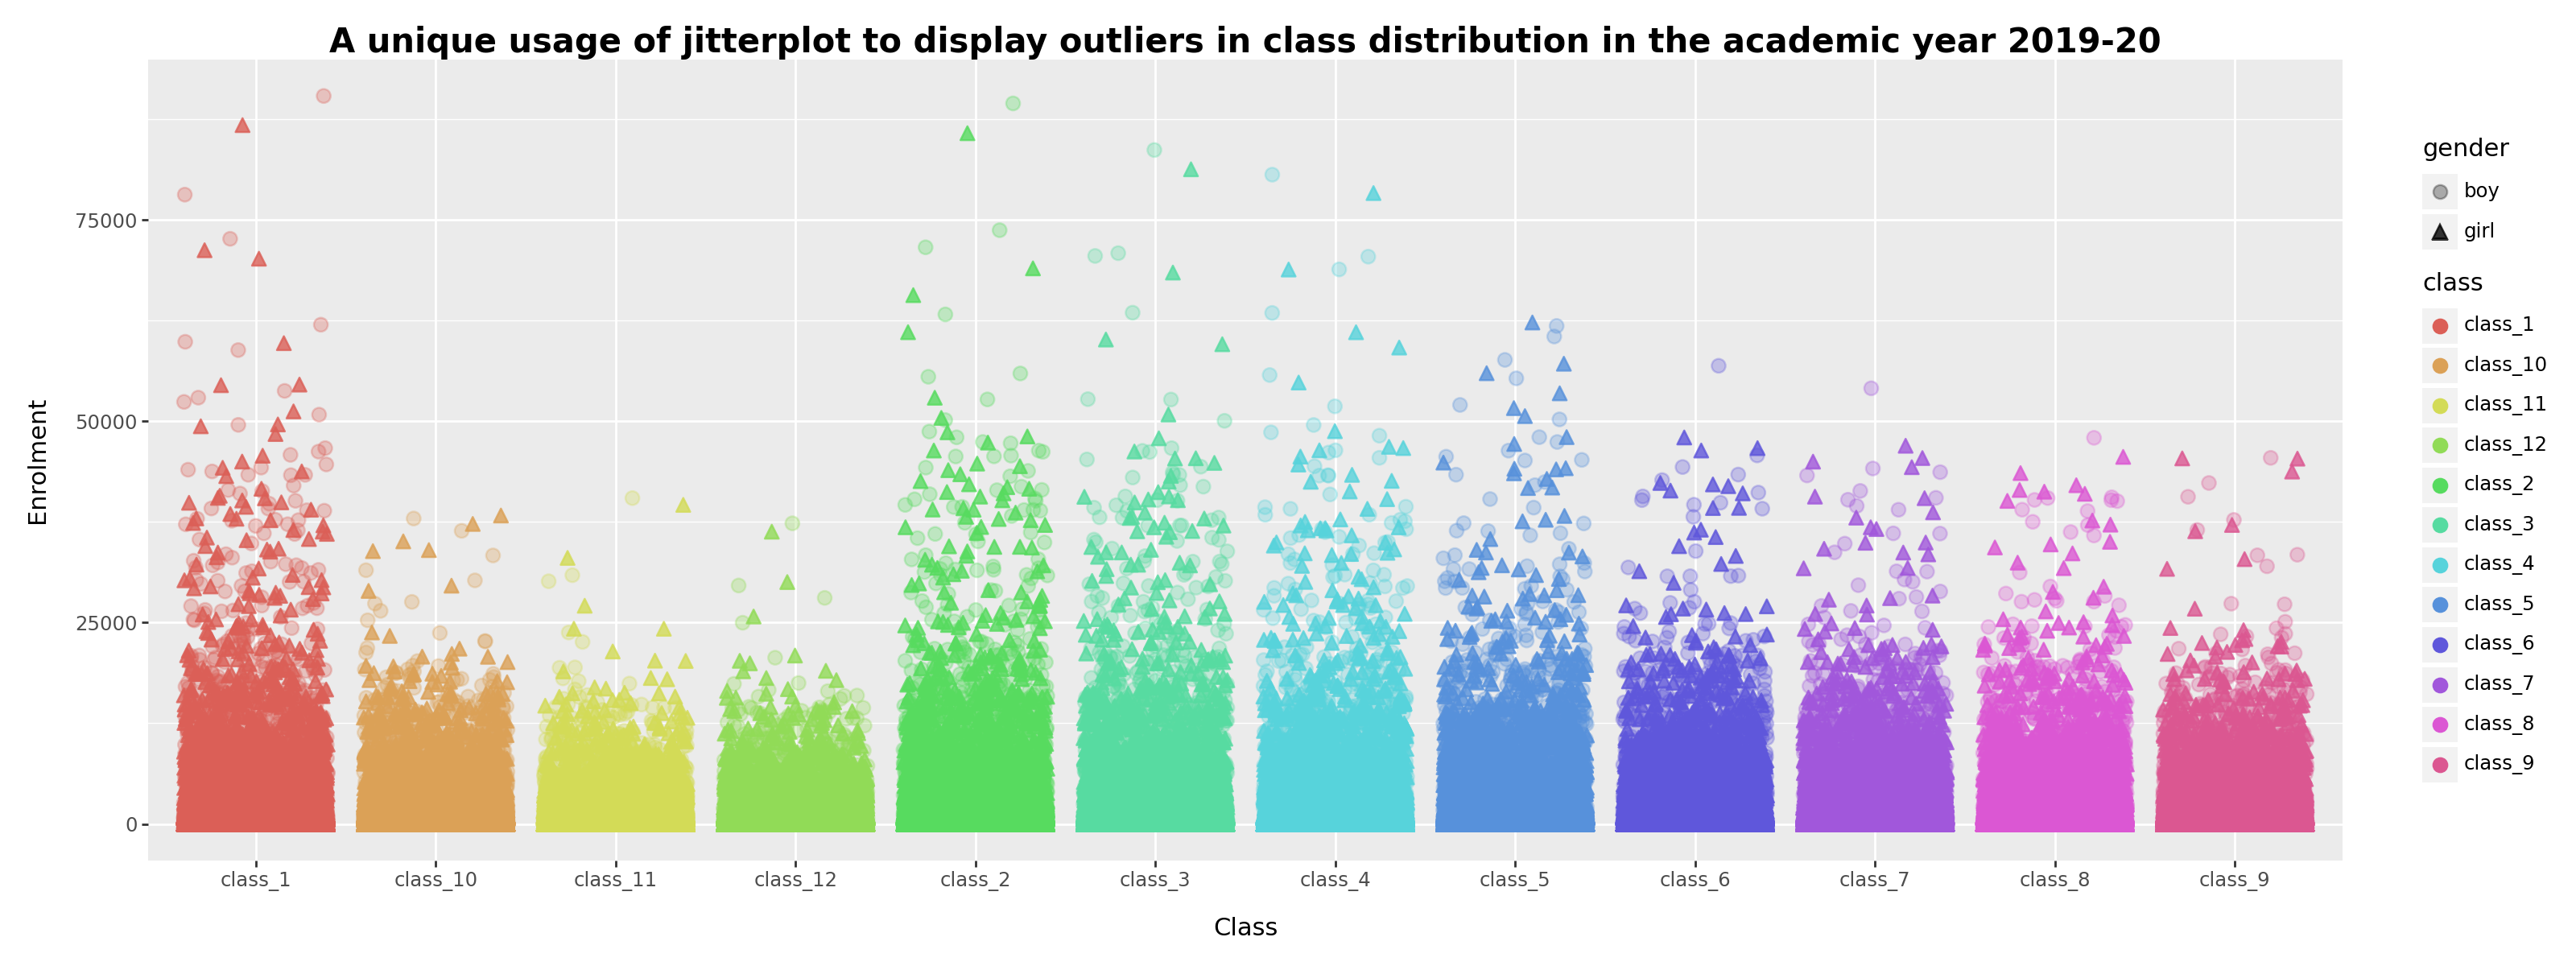

In [58]:
df = data[-1].copy()
df.drop(columns=df.columns[:5], inplace=True)
melt = pd.melt(df, id_vars=['district_name'], value_vars=df.columns[1:],
               var_name='class_gender', value_name='enrolment')
melt['gender'] = melt['class_gender'].map(
    lambda x: 'boy' if x.split('_')[2] == 'boys' else 'girl')
melt['class_gender'] = melt['class_gender'].map(
    lambda x: x.split('_')[0]+'_'+x.split('_')[1])
melt = melt.rename(columns={'class_gender': 'class'})


box = (ggplot(melt, aes(x='class', y='enrolment', group='class', color='class', fill='class',shape='gender',alpha='gender'))


       + geom_jitter(size=3)


       + theme(figure_size=[16, 6], 
               plot_title=element_text(weight='bold', ha='center', va='top', linespacing=3, size=15., margin={
                   't': 50,
               }))


       +scale_alpha_manual([0.3,0.8])
       + xlab('Class')
       +ylab('Enrolment')
       +ggtitle('A unique usage of jitterplot to display outliers in class distribution in the academic year 2019-20')
       )



print(box)

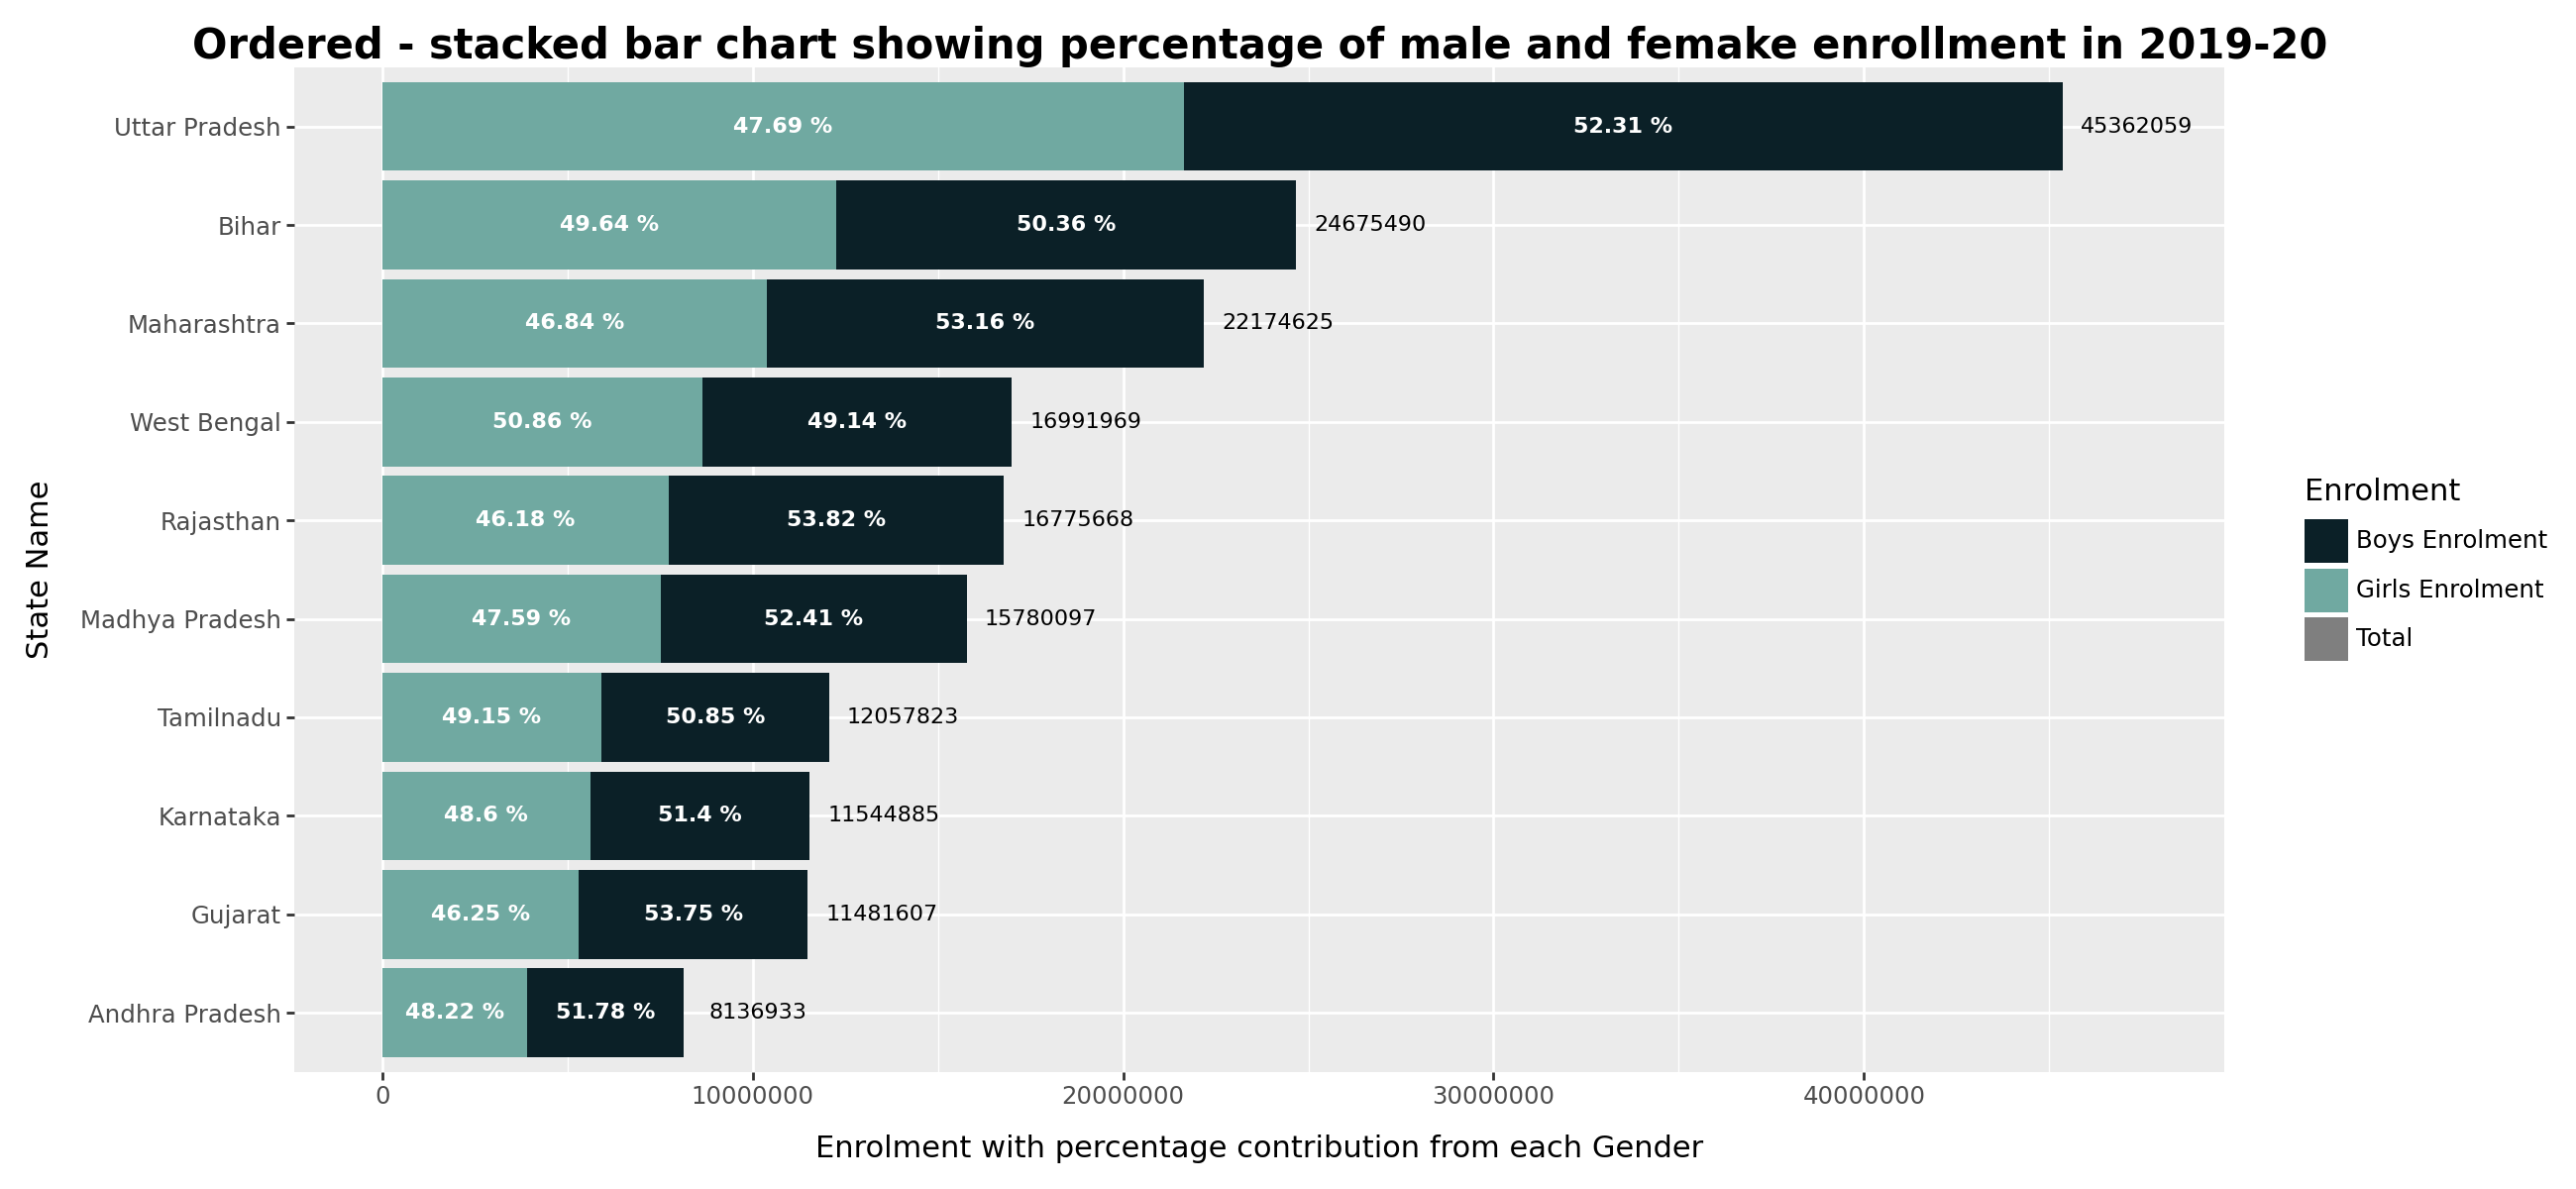

In [59]:
df = data[-1].copy()
df = df.groupby('state_name').sum().reset_index()
df = df.drop(columns=df.columns[1:6])
boys = [i for i in df.columns if 'boys' in i]
girls = [i for i in df.columns if 'girls' in i]
df['boys_enrolment'] = df[boys].sum(axis=1)
df['girls_enrolment'] = df[girls].sum(axis=1)
df.drop(columns=girls+boys, inplace=True)
df['total_enrolment'] = df['boys_enrolment'] + df['girls_enrolment']
df = df.sort_values(by='total_enrolment', ascending=False, ignore_index=True)
df = df[:10]
ndf = pd.DataFrame()
ndf['state_name'] = df['state_name']
ndf['total_enrolment'] = df['total_enrolment']
ndf['gender'] = 'Total'
colors = ['#0B2027', '#70A9A1']

df = pd.melt(df, id_vars=['state_name'], value_vars=['boys_enrolment', 'girls_enrolment'],
             var_name='gender', value_name='enrolment')


df['percentage'] = df['enrolment'] / \
    df.groupby('state_name')['enrolment'].transform('sum') * 100


df['label'] = df['percentage'].round(2).astype(str) + ' %'

stacked = (
    ggplot(df, aes(x='reorder(state_name, enrolment)', y='enrolment', fill='gender')) +
    geom_bar(stat='identity') +
    geom_text(aes(label='label'), size=8, position=position_stack(vjust=0.5), color='white', fontweight=600) +
    coord_flip() +
    geom_text(data=ndf, mapping=aes(x='state_name', y='total_enrolment', label='total_enrolment'), size=8, fontweight=500, nudge_y=2*1e6) +
    theme(figure_size=[13, 6], 
          plot_title=element_text(weight='bold', ha='center', va='top', linespacing=3, size=15., margin={
              't': 50,
          })) +
    guides(color=guide_legend(ncol=2,nrow=1))+
    scale_fill_manual(values=colors, name="Enrolment", labels={
                      "boys_enrolment": "Boys Enrolment", "girls_enrolment": "Girls Enrolment"})
    +xlab('State Name')+
    ylab('Enrolment with percentage contribution from each Gender')
    +ggtitle('Ordered - stacked bar chart showing percentage of male and femake enrollment in 2019-20')
)

print(stacked)

In [60]:
import plotly.express as px
import geopandas as gpd


state_mapping = {
    'Jammu & Kashmir': 'JAMMU AND KASHMIR',
    'Himachal Pradesh': 'HIMACHAL PRADESH',
    'Punjab': 'PUNJAB',
    'Chandigarh': 'CHANDIGARH',
    'Uttarakhand': 'UTTARAKHAND',
    'Haryana': 'HARYANA',
    'Delhi': 'DELHI',
    'Rajasthan': 'RAJASTHAN',
    'Uttar Pradesh': 'UTTAR PRADESH',
    'Bihar': 'BIHAR',
    'Sikkim': 'SIKKIM',
    'Arunachal Pradesh': 'ARUNACHAL PRADESH',
    'Nagaland': 'NAGALAND',
    'Manipur': 'MANIPUR',
    'Mizoram': 'MIZORAM',
    'Tripura': 'TRIPURA',
    'Meghalaya': 'MEGHALAYA',
    'Assam': 'ASSAM',
    'West Bengal': 'WEST BENGAL',
    'Jharkhand': 'JHARKHAND',
    'Odisha': 'ORISSA',
    'Chhattisgarh': 'CHHATTISGARH',
    'Madhya Pradesh': 'MADHYA PRADESH',
    'Gujarat': 'GUJARAT',
    'Daman & Diu': 'DAMAN AND DIU',
    'Dadra & Nagar Haveli': 'DADRA AND NAGAR HAVELI',
    'Maharashtra': 'MAHARASHTRA',
    'Andhra Pradesh': 'ANDHRA PRADESH',
    'Karnataka': 'KARNATAKA',
    'Goa': 'GOA',
    'Lakshadweep': 'LAKSHADWEEP',
    'Kerala': 'KERALA',
    'Tamilnadu': 'TAMIL NADU',
    'Puducherry': 'PONDICHERRY',
    'Andaman & Nicobar Islands': 'ANDAMAN AND NICOBAR ISLANDS',
    'Telangana': 'ANDHRA PRADESH',
    'Ladakh': 'JAMMU AND KASHMIR',
}


df = data[0].copy()
df['state_name'] = df['state_name'].map(state_mapping)
df = df.groupby('state_name').sum().reset_index().drop(columns=['ac_year','age','state_code','district_code','district_name'])
df['total'] = df[df.columns[1:]].sum(axis=1)
df = df.drop(columns=df.columns[1:-1])


india = gpd.read_file("outlines\India Shape\india_st.shp")
merged_data = india.merge(
    df, how='left', left_on='STATE', right_on='state_name')
fig = px.choropleth(data_frame=merged_data, geojson=merged_data.geometry, locations=merged_data.index,
                    color='total', hover_name='state_name', projection="mercator", color_continuous_scale='viridis')
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text='Enrolment by State')
fig.show(config={"scrollZoom": False})

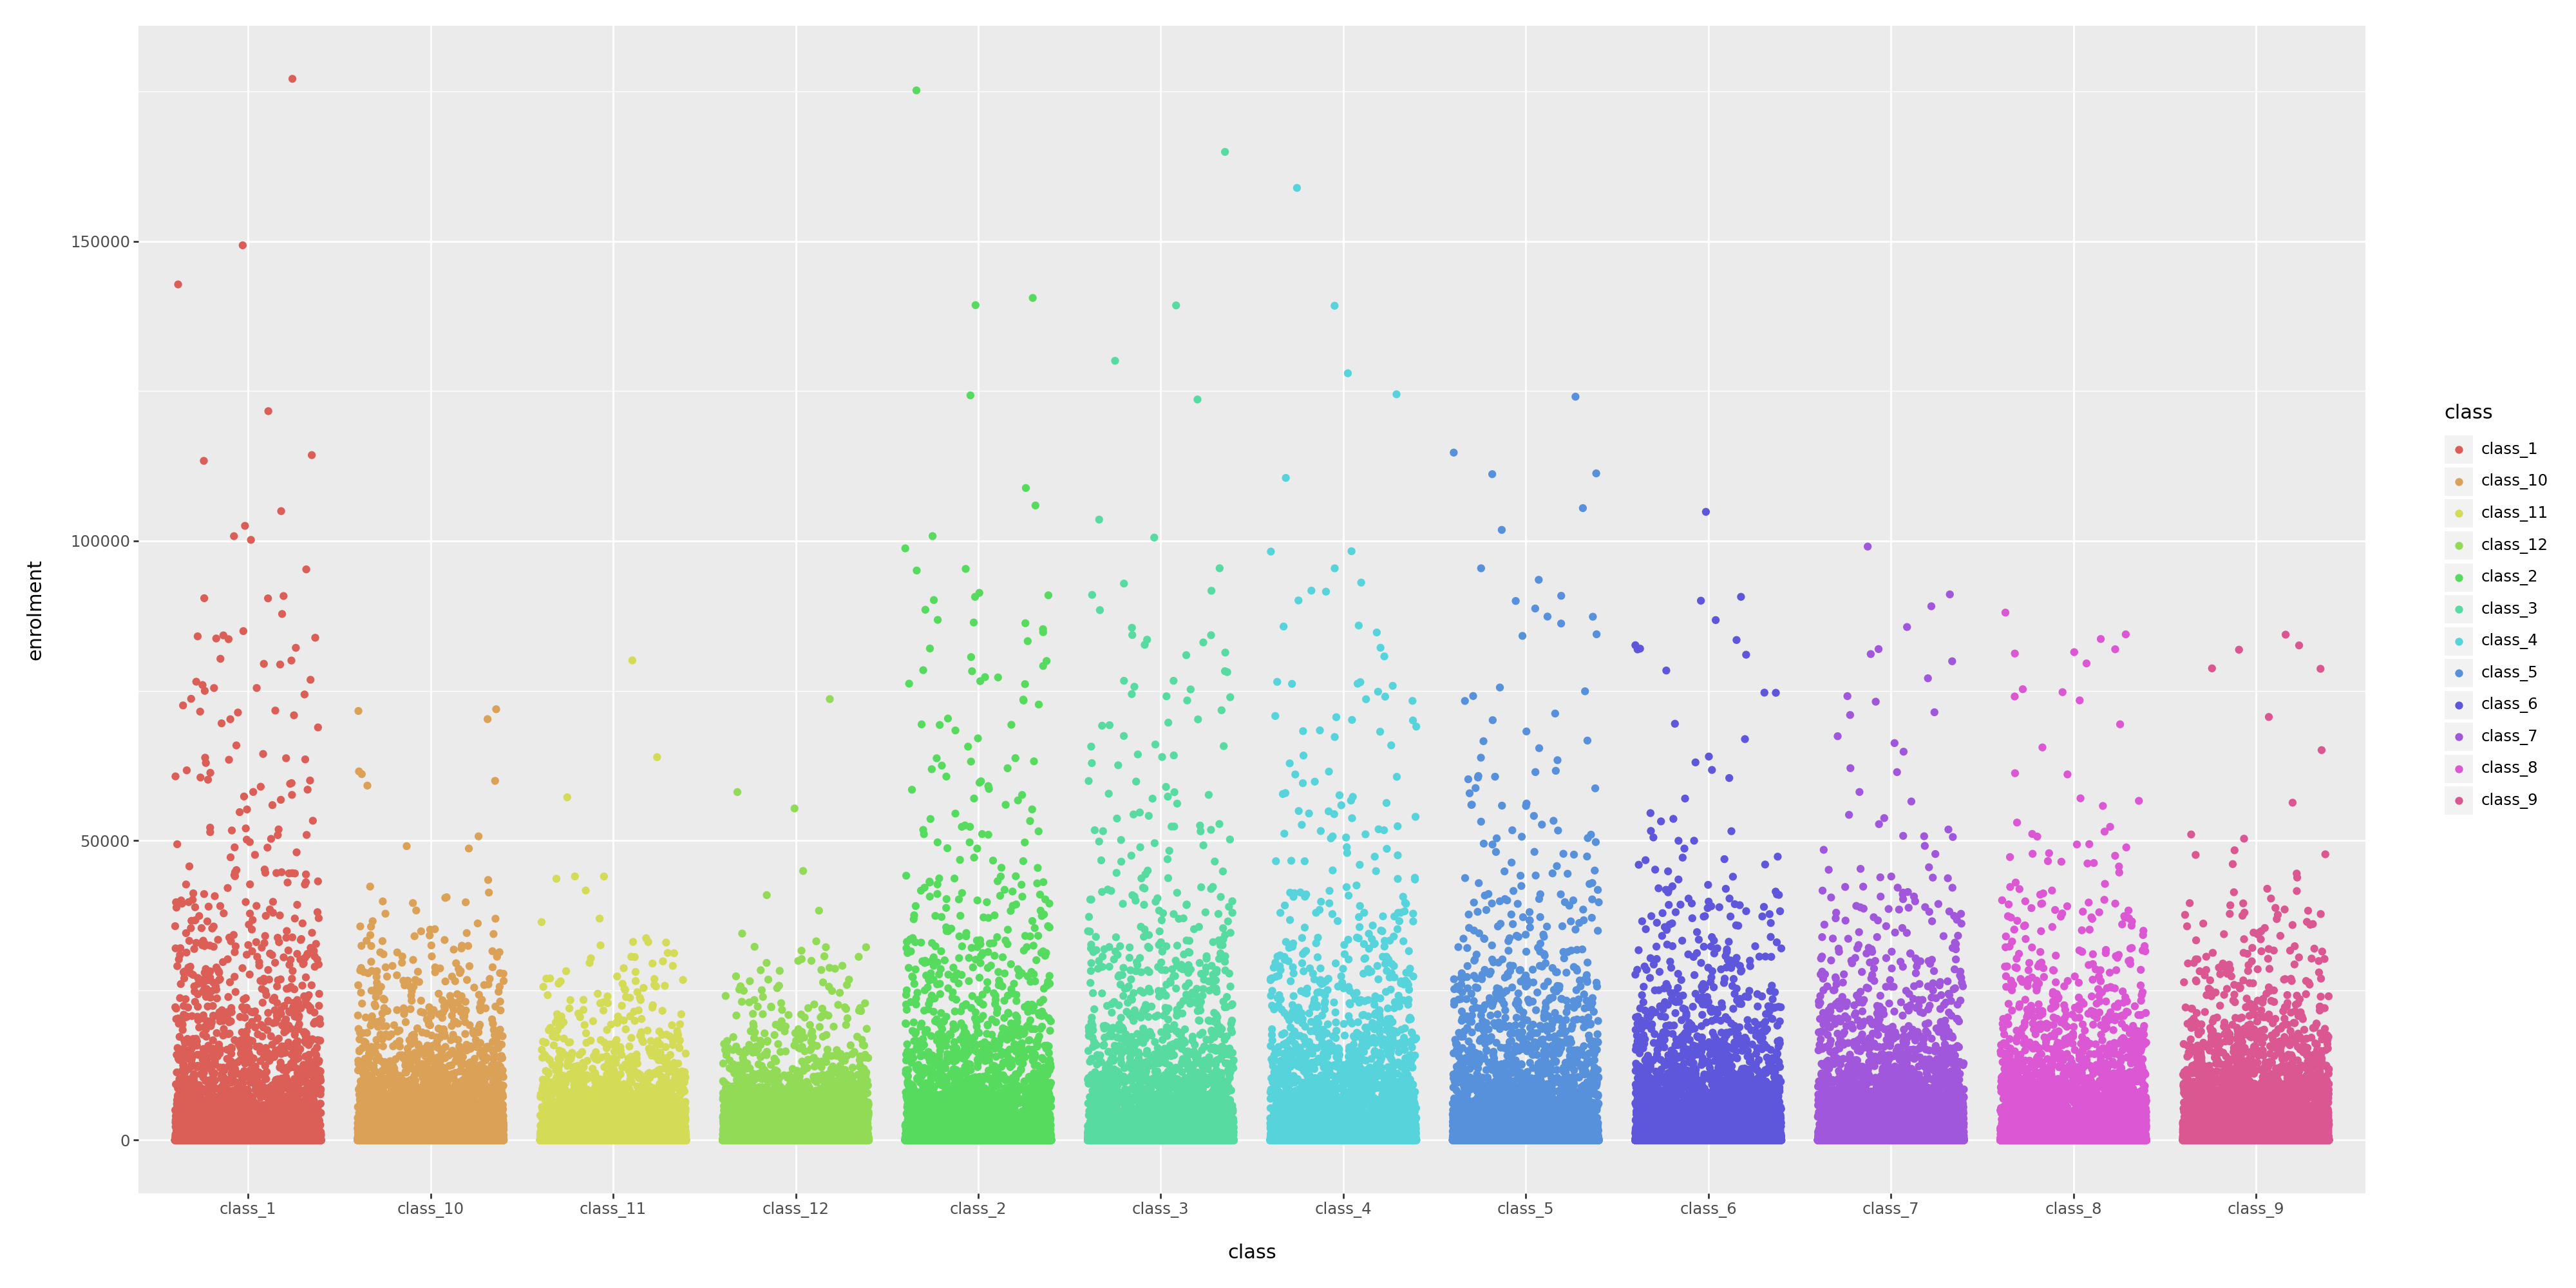

In [61]:

merged = data[-1]
for i in range(1,13):
    merged[f'class_{i}'] = merged[f'class_{i}_boys'] + merged[f'class_{i}_girls']

merged = merged.drop(columns=list(
    merged.columns[6:30])+list(merged.columns[1:5]))
merged = pd.melt(merged, id_vars=['ac_year','district_name'], var_name='class', value_vars=merged.columns[2:], value_name='enrolment')


jitter = ( ggplot(data=merged)+
          geom_jitter(mapping=aes(x='class',y='enrolment', color='class'))
          +theme(figure_size=[20,10])
          
          )

print(jitter)

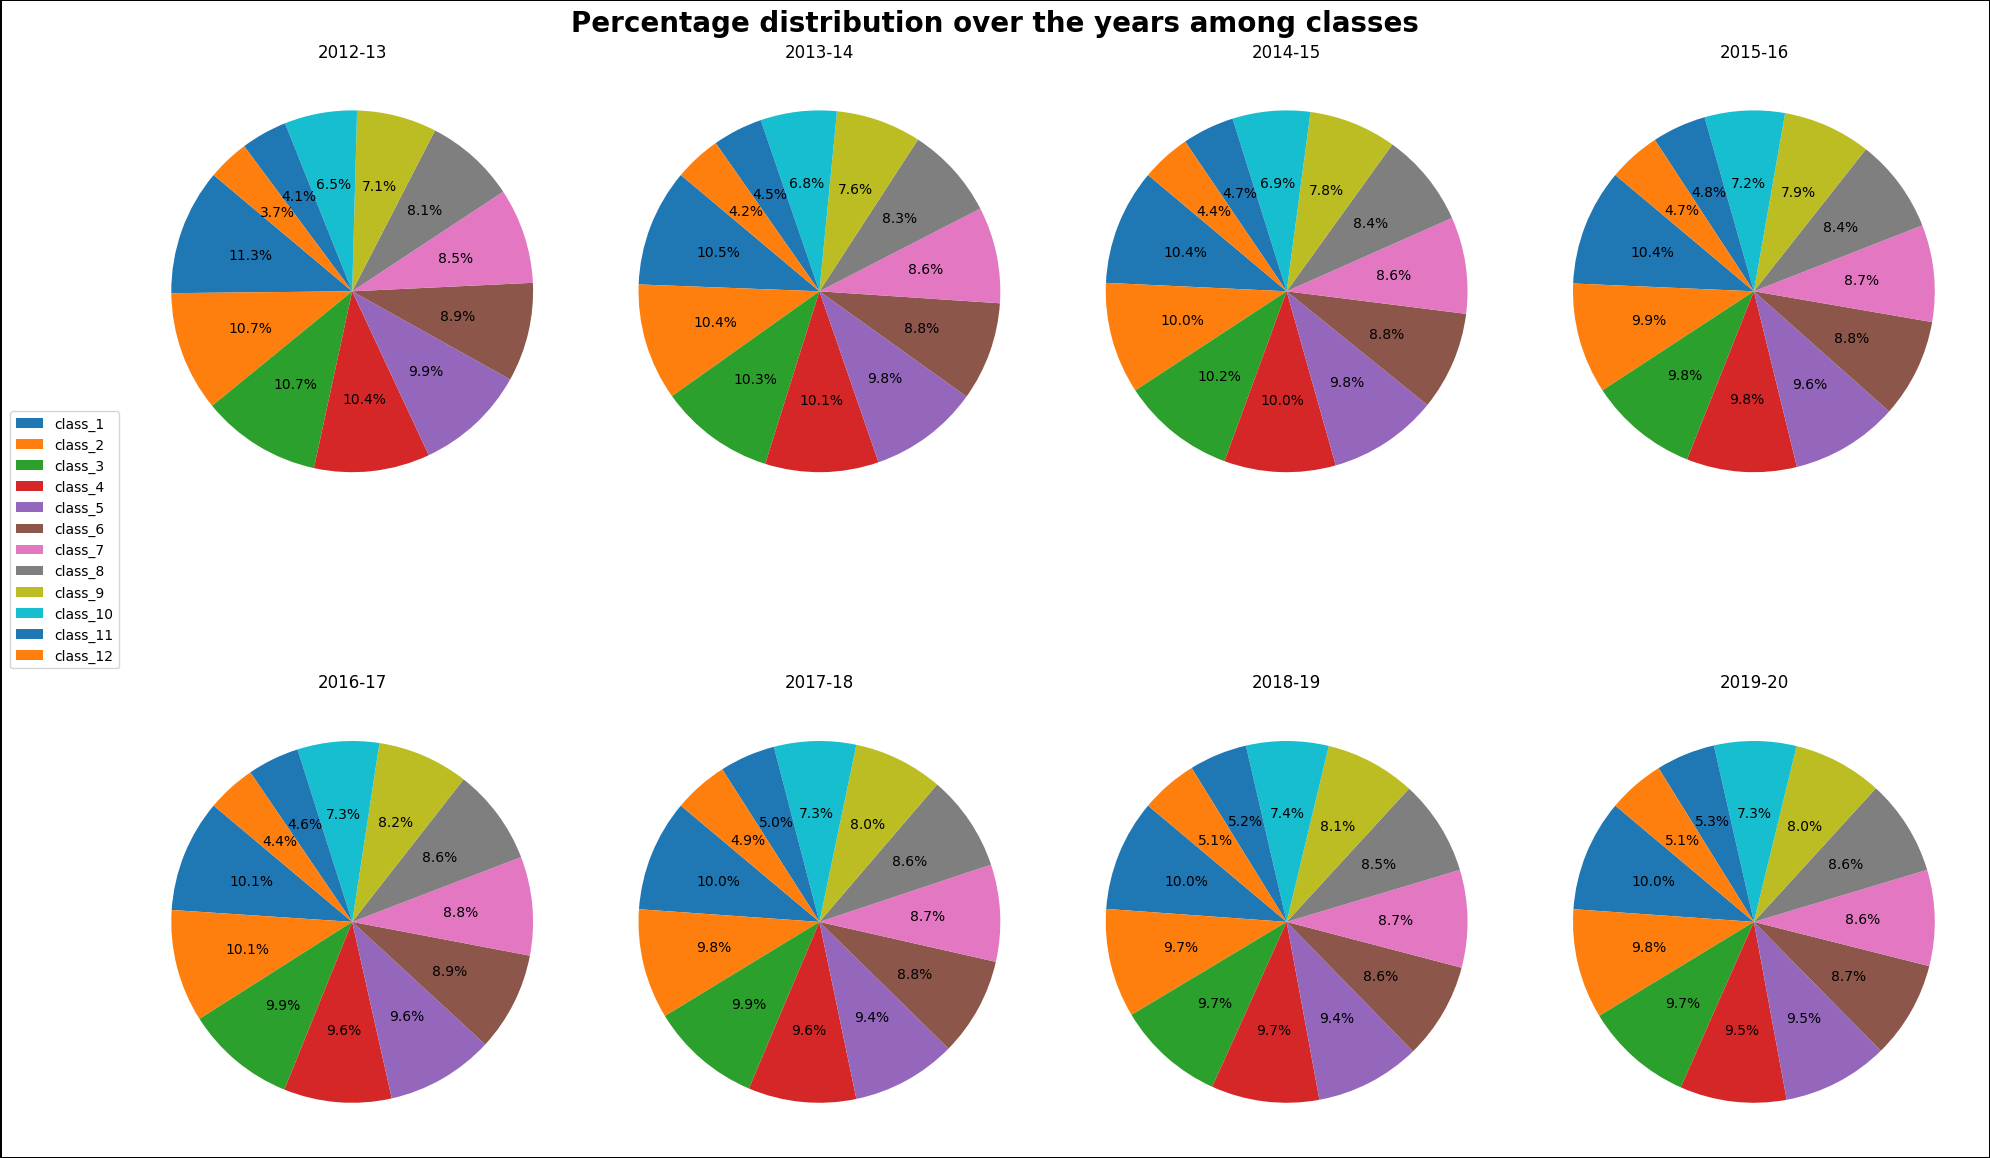

In [62]:
rows = 2
cols = 4
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=[20, 12])
labels = None

for i in range(len(data)):
    df = data[i].copy()
    ac_yr = df['ac_year'][0]
    df = df.drop(columns=df.columns[1:6])
    for k in range(1, 13):
        df[f'class_{k}'] = df[f'class_{k}_boys'] + df[f'class_{k}_girls']
    df = df.drop(columns=df.columns[1:25])
    labels = df.columns[1:]
    df = pd.DataFrame(df.sum(axis=0)[1:].reset_index())
    df = df.rename(columns={'index': 'class', 0: 'enrolment'})
    ax[i // cols][i % cols].pie(df['enrolment'], labels=[''] * len(df),
                                autopct='%1.1f%%', startangle=140)
    ax[i // cols][i % cols].set_title(f'{ac_yr}')

ax[0][0].legend(labels, bbox_to_anchor=(0, 0.25))
fig.suptitle('Percentage distribution over the years among classes',
             fontsize=20, fontweight=600)

fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(2)

plt.tight_layout()

plt.show()